# Making figure 4 and B2 of the paper
21/03/2025

In [26]:
import bagpipes as pipes
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 16})
import seaborn as sns
import os
from bagpipes import plotting
pipes.plotting.update_rcParams()
matplotlib.rcParams["axes.linewidth"] = 1.0

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

In [2]:
# change working directory to one layer above
os.chdir('..')
# set saving direction
save_dir = 'plots/'

In [61]:
# load in percentiles and samples tables
CPSB_post_df = pd.read_csv('data/posterior_samples_CPSB.csv')
RPSB_post_df = pd.read_csv('data/posterior_samples_RPSB_PSB.csv')
CPSB_percentiles = pd.read_csv('data/posterior_percentiles_CPSB.csv')
RPSB_percentiles = pd.read_csv('data/posterior_percentiles_RPSB_PSB.csv')

# convert halftime to in Gyr units
CPSB_post_df['halftime'] = CPSB_post_df['halftime']/1000
RPSB_post_df['halftime'] = RPSB_post_df['halftime']/1000
for p in [16,50,84]:
    CPSB_percentiles[f'halftime_{p}'] = CPSB_percentiles[f'halftime_{p}']/1000
    RPSB_percentiles[f'halftime_{p}'] = RPSB_percentiles[f'halftime_{p}']/1000

In [62]:
# remove PSBs with bad GP noise fits
CPSB_percentiles_ = CPSB_percentiles[CPSB_percentiles['GPnoise_flag']==0]
RPSB_percentiles_ = RPSB_percentiles[RPSB_percentiles['GPnoise_flag']==0]

In [63]:
ylabels = {
    "age": "$\\mathrm{Age}/\\mathrm{Gyr}$",
    "tau": "$\\tau/\\mathrm{Gyr}$",
    "alpha1": "$\\alpha_1$",
    "burstage": "$\\mathrm{Burst\\ Age}\\ /\\ \\mathrm{Gyr}$",
    "alpha2": "$\\alpha_2$",
    "alpha": "$\\alpha$",
    "halftime": "Half time $\\tau_{1/2}\\ /\\ \\mathrm{Gyr}$",
    "fburst" : "Burst mass fraction",
    "massformed": "mass formed / $\\mathrm{log_{10}(M_*/M_{\\odot})}$",
    "stellar_mass": "stellar mass / $\\mathrm{log_{10}(M_*/M_{\\odot})}$",
    "redshift": "Redshift",
    "veldisp": "$\\sigma_{vel}$",
    "sfr": "$\\mathrm{SFR}\\mathrm{M_\\odot\\ yr}^{-1}$",
    "ssfr": "$\\mathrm{log_{10}(sSFR\\mathrm{yr}^{-1})}$",
    "metallicity_old": "$Z_\\mathrm{old}/Z_{\\odot}$",
    "metallicity_burst": "$Z_\\mathrm{burst}/Z_{\\odot}$",
    "metallicity_slope": "$Z_\\mathrm{slope}/Z_{\\odot}\\ Gyr^{-1}$",
    "metallicity": "metallicity / $Z_*/Z_{\\odot}$",
    "metallicity_diff": "Metallicity change / $(Z_\\mathrm{burst} - Z_\\mathrm{old})/Z_{\\odot}$",
    "MW_zmet": "$Z_\\mathrm{*,MW}/Z_{\\odot}$",
    "log_MW_zmet_diff": "$\\log(Z_\\mathrm{*,MW}/Z_{\\odot}) - \\log(Z_\\mathrm{old}/Z_{\\odot})$",
    "log_metallicity_old": "Pre-burst metallicity / $\\log(Z_\\mathrm{old}/Z_{\\odot})$",
    "log_metallicity_burst": "Post-burst metallicity / $\\log(Z_\\mathrm{burst}/Z_{\\odot})$",
    "f1.0": "M(1.0Gyr) / M(total)",
    "f1.5": "M(1.5Gyr) / M(total)",
    "tquench_from_1": "quenching timescale $\\tau_{q2}\\ /\\ \\mathrm{Gyr}$",
    "tquench_from_peak": "quenching timescale $\\tau_{q1}\\ /\\ \\mathrm{Gyr}$",
    "Av": "$\\mathrm{A_V}$",
    "eta": "$\\eta_{\\mathrm{dust}}$"
}

## A bunch of set up functions

In [10]:
def alpha_to_halflife(alpha, tburst):
    # return in Gyr, assuming double powerlaw
    return (4**(1/alpha)-1)*tburst

def halflife_to_alpha(halflife, tburst):
    # halflife in Gyr, assuming double power law
    return np.log(4)/np.log((halflife+tburst)/tburst)

In [11]:
def comparison_plot(percentiles, Ngal, setting_choice, param1, param2, Nbins=15, 
                    figsize=[8,8], gs=None, fig=None, ax_list=None, errorbar=True, contour=False, post_samps=None, contour_levels=[0.5], 
                    recent_burst=False, low_fburst=False, low_fburst_light=False,
                    logx=False, logy=False, side_hist=True):
    """
    Makes the scatter plot, side histograms and errorbar/contour lines of the main property a vs property b plot
    
    Parameters
    ----------
    percentiles : pandas DataFrame
        table holding all posterior percentile values
    Ngal : int
        The number of galaxies (dots) to be plotted
    setting_choice : str
        The name of the set of runs (fits) to be plotted
    param1 : str
        The parameter name of the x-axis parameter
    param2 : str
        The parameter name of the y-axis parameter
    Nbins : int, optional
        The number of bins in the side histograms
    figsize : list, optional
        figure size, omitted if fig is passed
    gs : matplotlib Gridspec object, optional
        The gridspec from which to create the three panels. If passed, the function will not create its
        own figure
    fig : matplotlib figure object, optional
        The figure object. Must be passed along with gs
    ax_list : list of matplotlib axis objects, optional
        a list of axes in the order [main, hist_x, hist_y]. If passed, the function will not create its
        own axes, and instead plots on top of the provided axes
    errorbar : bool, optional
        If True, plots errorbars on each dot representing the 1sigma regions
    contour : bool, optional
        If True, plots single line contours around each dot representing the 2D 1sigma regions, requires
        post_samps to be passed
    post_samps : pandas DataFrame, optional
        table holding all posterior sample values, must be passed if contour = True
    contour_levels : list, optional
        The contour levels at which to draw them
    recent_burst : bool, optional
        If True, splits the sample into recent (burstage < 1.0Gyr) and old (burstage >= 1.0Gyr) samples, 
        plots each in different colours. Only one of recent_burst, low_fburst or low_fburst_light can be True.
    low_fburst : bool, optional
        If True, splits the sample into low (< 0.7) and high (>= 0.7) fburst samples,
        plots each in different colours. Only one of recent_burst, low_fburst or low_fburst_light can be True.
    low_fburst_light : bool, optional
        If True, splits the sample into low (< 0.9) and high (>= 0.9) light-weighted fburst samples,
        plots each in different colours. Only one of recent_burst, low_fburst or low_fburst_light can be True.
    logx : bool, optional
        If True, the x-axis's scale is in log
    logy : bool, optional
        If True, the y-axis's scale is in log
    side_hist : bool, optional
        If True, the side histograms will be plotted
    """
    
    # set global markers and colours
    marker1 = 'o'
    marker2 = '^'
    colour1 = 'tomato'
    colour2 = 'dodgerblue'
    
    # picking out the right galaxies in this setting choice
    setting_plateifu = percentiles[percentiles['setting']==setting_choice]['plateifu'].unique()
    
    # split the table into the two colour groups, by sorting indices
    if np.sum(int(recent_burst)+int(low_fburst)+int(low_fburst_light)) > 1:
        raise ValueError("Only one of recent_burst, low_fburst or low_fburst_light can be True.")
    if recent_burst:
        group1_ind, group2_ind = get_split_ind(
            percentiles, 'burstage', lambda x: x >= 1.0, lambda x: x < 1.0
        )
        
    elif low_fburst:
        group1_ind, group2_ind = get_split_ind(
            percentiles, 'fburst', lambda x: x < 0.7, lambda x: x >= 0.7
        )
                
    elif low_fburst_light:
        group1_ind, group2_ind = get_split_ind(
            percentiles, 'fburst_light', lambda x: x < 0.9, lambda x: x >= 0.9
        )
        
    else:
        group1_ind = np.arange(Ngal)
        group2_ind = []
            
    # sorting out percentiles into right galaxies
    p1_percentiles = np.zeros((3, Ngal))
    p2_percentiles = np.zeros((3, Ngal))
    for j,plateifu in enumerate(setting_plateifu):
        this_percentile_df = percentiles[(percentiles['setting']==setting_choice)&
                                         (percentiles['plateifu']==plateifu)]
        p1_percentiles[:,j] = np.array(this_percentile_df[[f'{param1}_16',f'{param1}_50',f'{param1}_84']])
        p2_percentiles[:,j] = np.array(this_percentile_df[[f'{param2}_16',f'{param2}_50',f'{param2}_84']])
        
    # making plot
    if ax_list is not None:
        if (logx or logy) & (contour) & ax_list[3] is None:
            raise ValueError(f"For log axis scale and contour, a log axis needs to be passed. Currently the 4th axis in ax_list is None.")
        [ax, ax_histx, ax_histy, ax_log] = ax_list
        
    else:
        # no passed ax_list, create from scratch
        if side_hist:
            if gs is None:
                # no passed figure and gridspec, create figure
                fig = plt.figure(figsize=figsize)
                this_gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                                  left=0.1, right=0.9, bottom=0.1, top=0.9,
                                  wspace=0.05, hspace=0.05)
            else:
                # gridspec passed, use subgridspec to create axes
                this_gs = gs.subgridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                                  wspace=0.05, hspace=0.05)
            ax = fig.add_subplot(this_gs[1, 0])
            ax_histx = fig.add_subplot(this_gs[0, 0], sharex=ax)
            ax_histy = fig.add_subplot(this_gs[1, 1], sharey=ax)
                
        else:
            # no side histograms, straight forward
            if gs is None:
                fig,ax = plt.subplots(figsize=figsize)
            else:
                ax = plt.subplot(gs)
            ax_histx = None
            ax_histy = None
            
        # add overlaying subplots in the same dimension as the main plot to put contour lines if anything is logged
        if (logx or logy) & (contour):
            if side_hist:
                ax_log = fig.add_subplot(this_gs[1, 0])
            else:
                if gs is None:
                    ax_log = fig.add_subplot(111)
                else:
                    ax_log = fig.add_subplot(gs)
            ax_log.xaxis.set_visible(False)
            ax_log.yaxis.set_visible(False)
            ax_log.patch.set_alpha(0)
        else:
            ax_log = None

    # scatter
    _scatter(ax, p1_percentiles, p2_percentiles, group1_ind, group2_ind, 
             recent_burst, low_fburst, low_fburst_light, colour1, colour2, marker1, marker2)
    
    # errorbar
    if errorbar:
        _errorbar(ax, p1_percentiles, p2_percentiles, group1_ind, group2_ind, 
                  recent_burst, low_fburst, low_fburst_light, colour1, colour2)
    
    # contours from seaborn.kdeplot
    if contour:
        _contour(ax, post_samps, setting_choice, param1, param2, setting_plateifu, colour1, colour2, contour_levels, logx, logy, 
                 group1_ind, group2_ind, ax_log=ax_log)
    
    # side histograms
    if side_hist:
        _side_histograms(ax_histx, ax_histy, p1_percentiles, p2_percentiles, group1_ind, group2_ind, 
                         recent_burst, low_fburst, low_fburst_light, colour1, colour2, logx, logy, Nbins=Nbins)
        
    if ax_list is None:
        # set some labels
        ax.set_xlabel(ylabels[param1])
        ax.set_ylabel(ylabels[param2])
        if side_hist:
            ax_histx.tick_params(axis="x", labelbottom=False)
            ax_histy.tick_params(axis="y", labelleft=False)
        
    return fig, [ax,ax_histx,ax_histy,ax_log]

def get_split_ind(percentiles, parameter, split_func1, split_func2):
    """
    percentiles: the big df with the _16, _50 and _84 columns for each parameter
    parameter: the parameter to split on, auto assume it is the _50 column
    split_func1: the splitting function for group 1
    split_func2: the splitting function for group 2
    """
    
    group1_ind = []
    group2_ind = []
    count = 0
    for i,row in percentiles.iterrows():
        if split_func1(row[parameter+'_50']):
            group1_ind.append(count)
        elif split_func2(row[parameter+'_50']):
            group2_ind.append(count)
        count += 1
    
    return group1_ind, group2_ind

def _scatter(ax, p1_percentiles, p2_percentiles, percentile1_ind, percentile2_ind, 
             recent_burst, low_fburst, low_fburst_light, colour1, colour2, marker1, marker2):
    
    # check for open circle markers
    if marker1 == 'O':
        marker1 = 'o'
        facecolour1 = 'w'
    else:
        facecolour1 = colour1
    edgecolour1 = colour1
    
    if marker2 == 'O':
        marker2 = 'o'
        facecolour2 = 'w'
    else:
        facecolour2 = colour2
    edgecolour2 = colour2
    
    if recent_burst or low_fburst or low_fburst_light:
        ax.scatter(p1_percentiles[1][percentile1_ind], p2_percentiles[1][percentile1_ind], 
                   facecolor=facecolour1, edgecolour=edgecolor1, marker=marker1, s=50, zorder=1, label=label1)
        ax.scatter(p1_percentiles[1][percentile2_ind], p2_percentiles[1][percentile2_ind], 
                   facecolor=facecolour2, edgecolour=edgecolor2, marker=marker2, s=50, zorder=1, label=label2)
    else:
        ax.scatter(p1_percentiles[1], p2_percentiles[1], 
                   facecolor=facecolour1, edgecolor=edgecolour1, marker=marker1, s=50, zorder=1)
    
def _errorbar(ax, p1_percentiles, p2_percentiles, percentile1_ind, percentile2_ind, 
              recent_burst, low_fburst, low_fburst_light, colour1, colour2):
    
    if recent_burst or low_fburst or low_fburst_light:
        ax.errorbar(p1_percentiles[1][percentile1_ind], p2_percentiles[1][percentile1_ind], 
                    xerr=[p1_percentiles[1][percentile1_ind]-p1_percentiles[0][percentile1_ind], 
                          p1_percentiles[2][percentile1_ind]-p1_percentiles[1][percentile1_ind]],
                    yerr=[p2_percentiles[1][percentile1_ind]-p2_percentiles[0][percentile1_ind], 
                          p2_percentiles[2][percentile1_ind]-p2_percentiles[1][percentile1_ind]],
                       color=colour1, fmt='.', zorder=-1, alpha=0.7)
        ax.errorbar(p1_percentiles[1][percentile2_ind], p2_percentiles[1][percentile2_ind], 
                    xerr=[p1_percentiles[1][percentile2_ind]-p1_percentiles[0][percentile2_ind], 
                          p1_percentiles[2][percentile2_ind]-p1_percentiles[1][percentile2_ind]],
                    yerr=[p2_percentiles[1][percentile2_ind]-p2_percentiles[0][percentile2_ind], 
                          p2_percentiles[2][percentile2_ind]-p2_percentiles[1][percentile2_ind]],
                       color=colour2, fmt='.', zorder=-1, alpha=0.7)
    else:
        ax.errorbar(p1_percentiles[1], p2_percentiles[1], 
                    xerr=[p1_percentiles[1]-p1_percentiles[0], 
                          p1_percentiles[2]-p1_percentiles[1]],
                    yerr=[p2_percentiles[1]-p2_percentiles[0], 
                          p2_percentiles[2]-p2_percentiles[1]],
                       color=colour1, fmt='none', zorder=-1, alpha=0.25)
    
def _contour(ax, post_samps, setting_choice, param1, param2, setting_plateifu, colour1, colour2, contour_levels, logx, logy, 
             percentile1_ind, percentile2_ind, ax_log=None):
    
    for j,plateifu in enumerate(setting_plateifu):
        if j in percentile1_ind:
            this_colour = colour1
        elif j in percentile2_ind:
            this_colour = colour2
        this_post_df = post_samps[(post_samps['plateifu']==plateifu) & 
                                  (post_samps['setting']==setting_choice)].copy()
        if (logx or logy) is False:
            sns.kdeplot(data=this_post_df, x=param1, y=param2, levels=contour_levels, cut=0, 
                        color=this_colour, alpha=0.5, ax=ax, zorder=-2)
        elif logx:
            this_post_df['log_param1'] = np.log10(this_post_df[param1])
            sns.kdeplot(data=this_post_df, x='log_param1', y=param2, levels=contour_levels, cut=0, 
                        color=this_colour, alpha=0.5, ax=ax_log, zorder=-2)

        elif logy:
            this_post_df['log_param2'] = np.log10(this_post_df[param2])
            sns.kdeplot(data=this_post_df, x=param1, y='log_param2', levels=contour_levels, cut=0, 
                        color=this_colour, alpha=0.5, ax=ax_log, zorder=-2)
            
def _side_histograms(ax_histx, ax_histy, p1_percentiles, p2_percentiles, percentile1_ind, percentile2_ind, 
                     recent_burst, low_fburst, low_fburst_light, colour1, colour2, logx, logy, Nbins=15, binsx=None, binsy=None):
    # get bin limits
    if binsx is not None:
        histx, _ = np.histogram(p1_percentiles[1], bins=binsx)
    else:
        if logx:
            # deal with log quantity
            binsx = 10**np.linspace(np.log10(min(p1_percentiles[1])), np.log10(max(p1_percentiles[1])), Nbins)
            histx, _ = np.histogram(p1_percentiles[1], bins=binsx)
        else:
            histx, binsx = np.histogram(p1_percentiles[1], bins=Nbins)
        
    if binsy is not None:
        histy, _ = np.histogram(p2_percentiles[1], bins=binsy)
    else:
        if logy:
            # deal with log quantity
            binsy = 10**np.linspace(np.log10(min(p2_percentiles[1])), np.log10(max(p2_percentiles[1])), Nbins)
            histy, _ = np.histogram(p2_percentiles[1], bins=binsy)
        else:
            histy, binsy = np.histogram(p2_percentiles[1], bins=Nbins)
    
    if recent_burst or low_fburst or low_fburst_light:
        ax_histx.hist(p1_percentiles[1][percentile1_ind],
                      bins=binsx, color=colour1, stacked=False,
                      alpha=0.3)
        ax_histx.hist(p1_percentiles[1][percentile2_ind],
                      bins=binsx, color=colour2, stacked=False,
                      alpha=0.3)
        # make the outlines on the hists
        hx1, edgesx1 = np.histogram(p1_percentiles[1][percentile1_ind], bins=binsx)
        ax_histx.stairs(hx1, edgesx1, color=colour1)
        hx2, edgesx2 = np.histogram(p1_percentiles[1][percentile2_ind], bins=binsx)
        ax_histx.stairs(hx2, edgesx2, color=colour2)
        
        ax_histy.hist(p2_percentiles[1][percentile1_ind],
                      bins=binsy, color=colour1, stacked=False,
                      alpha=0.3, orientation='horizontal')
        ax_histy.hist(p2_percentiles[1][percentile2_ind],
                      bins=binsy, color=colour2, stacked=False,
                      alpha=0.3, orientation='horizontal')
        # make the outlines on the hists
        hy1, edgesy1 = np.histogram(p2_percentiles[1][percentile1_ind], bins=binsy)
        ax_histy.stairs(hy1, edgesy1, color=colour1, orientation='horizontal')
        hy2, edgesy2 = np.histogram(p2_percentiles[1][percentile2_ind], bins=binsy)
        ax_histy.stairs(hy2, edgesy2, color=colour2, orientation='horizontal')
        
    else:
        ax_histx.hist(p1_percentiles[1], bins=binsx, color=colour1, stacked=False,
                      alpha=0.3)
        ax_histy.hist(p2_percentiles[1], bins=binsy, color=colour1, stacked=False,
                      alpha=0.3, orientation='horizontal')
        # make the outlines on the hists
        hx, edgesx = np.histogram(p1_percentiles[1], bins=binsx)
        ax_histx.stairs(hx, edgesx, color=colour1)
        hy, edgesy = np.histogram(p2_percentiles[1], bins=binsy)
        ax_histy.stairs(hy, edgesy, color=colour1, orientation='horizontal')

In [17]:
def get_bin_edges(v_dict, Nbins, edges=None):
    if edges is None:
        edges = v_dict['range']
        
    if 'prior' in v_dict.keys():
        div = (np.log10(edges[1])-np.log10(edges[0]))/Nbins
        bin_edges = 10**(np.arange(Nbins+1)*div + np.log10(edges[0]))
        
    else:
        div = (edges[1]-edges[0])/Nbins
        bin_edges = np.arange(Nbins+1)*div + edges[0]
        
    return bin_edges

def cal_prob2d(variables, paramx, paramy, Nbins, chen2019_mask, additional_mask=None, 
               xlims=None, ylims=None):
    v_dictx = variables[paramx]
    bin_edgesx = get_bin_edges(v_dictx, Nbins, edges=xlims)

    v_dicty = variables[paramy]
    bin_edgesy = get_bin_edges(v_dicty, Nbins, edges=ylims)

    if additional_mask is None:
        overall_xvals = rand_vals[:,list(variables.keys()).index(paramx)]
        overall_yvals = rand_vals[:,list(variables.keys()).index(paramy)]
        PSB_xvals = rand_vals[:,list(variables.keys()).index(paramx)][chen2019_mask]
        PSB_yvals = rand_vals[:,list(variables.keys()).index(paramy)][chen2019_mask]
    else:
        overall_xvals = rand_vals[:,list(variables.keys()).index(paramx)][additional_mask]
        overall_yvals = rand_vals[:,list(variables.keys()).index(paramy)][additional_mask]
        # dot product of the two masks
        PSBxadditional_mask = chen2019_mask * additional_mask
        PSB_xvals = rand_vals[:,list(variables.keys()).index(paramx)][PSBxadditional_mask]
        PSB_yvals = rand_vals[:,list(variables.keys()).index(paramy)][PSBxadditional_mask]
    
    overall_hist = np.histogram2d(overall_xvals, overall_yvals, 
                                  bins = (bin_edgesx, bin_edgesy))[0].T
    PSB_hist = np.histogram2d(PSB_xvals, PSB_yvals, 
                                  bins = (bin_edgesx, bin_edgesy))[0].T
    # mask any bins with less than 10^-4 fraction of the overall sample size within the limits given
    min_bin_size = np.sum(overall_hist)*1e-4
    PSB_hist[overall_hist<min_bin_size] = 0
    overall_hist[overall_hist<min_bin_size] = 0
    
    X, Y = np.meshgrid(bin_edgesx, bin_edgesy)
    
    return X, Y, PSB_hist/overall_hist

def cal_prob1d(variables, param, Nbins, chen2019_mask, additional_mask=None, lims=None):
    v_dict = variables[param]
    bin_edges = get_bin_edges(v_dict, Nbins, edges=lims)
    
    if additional_mask is None:
        overall_vals = rand_vals[:,list(variables.keys()).index(param)]
        PSB_vals = rand_vals[:,list(variables.keys()).index(param)][chen2019_mask]
    else:
        overall_vals = rand_vals[:,list(variables.keys()).index(param)][additional_mask]
        # dot product of the two masks
        PSBxadditional_mask = chen2019_mask * additional_mask
        PSB_vals = rand_vals[:,list(variables.keys()).index(param)][PSBxadditional_mask]
        
    overall_hist = np.histogram(overall_vals, bin_edges)[0]
    PSB_hist = np.histogram(PSB_vals, bin_edges)[0]
    # mask any bins with less than 10^-3 fraction of the overall sample size within the limits given
    min_bin_size = np.sum(overall_hist)*1e-3
    PSB_hist[overall_hist<min_bin_size] = 0
    overall_hist[overall_hist<min_bin_size] = 0
    
    return bin_edges, PSB_hist/overall_hist

In [15]:
# load in and compute the simulated sample of PSBs from bagpipes, and whether they will be picked up by
# Chen+2019 limits
runID = 'N100000_redshift0.01to0.05_zmet1to2.5Zsun_bagpipesinternal'
# create grids of random numbers to be sampled
massformed = {'range':[8,11]}
age = {'range':[4,14]}
tau = {'range':[0.3, 10]}
burstage = {'range':[0, 4]}
# alpha < 40 will never qualify for the quenching timescale criteria of <250Myr
alpha = {'range':[40, 1000], 'prior':'log_10'}
fburst = {'range':[0,1]}
metallicity_old = {'range':[0.01, 5.0], 'prior':'log_10'}
metallicity_burst = {'range':[0.01, 5.0], 'prior':'log_10'}
metallicity_diff = {'range':[-2.5,2.5]}
Av = {'range':[0,2]}
eta = {'range':[1,5]}
veldisp = {'range':[40,200], 'prior':'log_10'}
redshift = {'range':[0.01, 0.05]}
log_metallicity_old = {'range':[np.log10(0.01), np.log10(2.5)]}
log_metallicity_burst = {'range':[np.log10(0.01), np.log10(2.5)]}
log_zmet_diff = {'range':[np.log10(0.01)-np.log10(2.5), np.log10(2.5)-np.log10(0.01)]}
halftime = {'range':[0.012379966721233671, 2.0768179358894304e+61], 'prior':'log_10'}

variables = {'massformed':massformed, 'age':age, 'tau':tau, 'burstage':burstage, 'alpha':alpha, 'fburst':fburst, 
             'metallicity_old':metallicity_old, 'metallicity_burst':metallicity_burst, 
             'Av':Av, 'eta':eta, 'veldisp':veldisp, 'redshift':redshift, 'metallicity_diff':metallicity_diff,
             'log_metallicity_old':log_metallicity_old, 'log_metallicity_burst':log_metallicity_burst,
             'log_zmet_diff':log_zmet_diff,
             'halftime':halftime}

rand_vals = np.load(f'data/PSB_selection_visibility/random_inputs_{runID}.npy')
EW_HdeltaA = np.load(f'data/PSB_selection_visibility/EW_HdeltaA_{runID}.npy')
EW_Halpha = np.load(f'data/PSB_selection_visibility/EW_Halpha_{runID}.npy')
# mask away mocks with metallicity>2.5
mask = (rand_vals[:,6]<=2.5) & (rand_vals[:,7]<=2.5)
rand_vals = rand_vals[mask]
EW_HdeltaA = EW_HdeltaA[mask]
EW_Halpha = EW_Halpha[mask]

rand_vals[:,6] = rand_vals[:,6]*0.02/0.0142
rand_vals[:,7] = rand_vals[:,7]*0.02/0.0142
metallicity_diff_vals = rand_vals[:,6] - rand_vals[:,5]
rand_log_metallicity_old = np.log10(rand_vals[:,list(variables.keys()).index('metallicity_old')])
rand_log_metallicity_burst = np.log10(rand_vals[:,list(variables.keys()).index('metallicity_burst')])
rand_log_zmet_diff = np.log10(rand_vals[:,list(variables.keys()).index('metallicity_burst')]) - \
                     np.log10(rand_vals[:,list(variables.keys()).index('metallicity_old')])
rand_tburst = cosmo.age(rand_vals[:,list(variables.keys()).index('redshift')]).value- \
                        rand_vals[:,list(variables.keys()).index('burstage')]
rand_halftime = alpha_to_halflife(rand_vals[:,list(variables.keys()).index('alpha')], rand_tburst)
rand_vals = np.append(rand_vals, np.array([metallicity_diff_vals, rand_log_metallicity_old, 
                                           rand_log_metallicity_burst, rand_log_zmet_diff,
                                           rand_halftime]).T, axis=1)

# limit to metallicity > 0.1 for both levels
high_z_ind = (rand_vals[:,list(variables.keys()).index('metallicity_old')]>=0.01) & \
    (rand_vals[:,list(variables.keys()).index('metallicity_burst')]>=0.01)
rand_vals = rand_vals[high_z_ind,:]
EW_HdeltaA = EW_HdeltaA[high_z_ind]
EW_Halpha = EW_Halpha[high_z_ind]

chen2019_mask = ((EW_HdeltaA>3) & 
                 (EW_Halpha<10) & 
                 (np.log10(EW_Halpha)<0.23*EW_HdeltaA-0.46))
print('Total no of classified PSB:', np.sum(chen2019_mask))

Total no of classified PSB: 29666


/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_87420/3925515880.py:63: RuntimeWarning: divide by zero encountered in log10
  (np.log10(EW_Halpha)<0.23*EW_HdeltaA-0.46))


In [18]:
# truncate Greys colourmap to remove darker portion
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Greys')
new_cmap = truncate_colormap(cmap, 0, 0.5)

In [19]:
def control_hist(ax_histx, ax_histy, xparam, yparam, Nbins, chen2019_mask, xlims, ylims, additional_mask):
    x_edges, probx = cal_prob1d(variables, xparam, Nbins, chen2019_mask, lims=xlims, 
                            additional_mask=additional_mask)
    ax_histx2 = ax_histx.twinx()
    ax_histx2.stairs(probx, edges=x_edges, color='k', zorder=-1)
    ax_histx2.set_ylabel(r'$P_\mathrm{select}$', fontsize=18)
    ax_histx2.set_ylim([0,1])

    y_edges, proby = cal_prob1d(variables, yparam, Nbins, chen2019_mask, lims=ylims, 
                                additional_mask=additional_mask)
    ax_histy2 = ax_histy.twiny()
    ax_histy2.stairs(proby, edges=y_edges, color='k', zorder=-1, orientation='horizontal')
    ax_histy2.set_xlabel(r'$P_\mathrm{select}$', fontsize=18)
    ax_histy2.set_xlim([0,1])
    ax_histy2.set_xticks([0,0.5,1.0], labels=['','$0.5$','$1.0$'])

In [64]:
def comparison_plot_single(percentiles, Ngal, setting_choice, param1, param2, color, marker, Nbins=15, 
                    figsize=[8,8], gs=None, fig=None, ax_list=None, errorbar=True, contour=False, post_samps=None, contour_levels=[0.5], 
                    logx=False, logy=False, binsx=None, binsy=None, side_hist=True):
    
    # picking out the right galaxies in this setting choice
    setting_plateifu = list(percentiles['plateifu'])
    
    percentile1_ind = np.arange(Ngal)
    percentile2_ind = []
            
    # sorting out percentiles into right galaxies
    p1_percentiles = percentiles[[f'{param1}_16', f'{param1}_50', f'{param1}_84']].to_numpy().T
    p2_percentiles = percentiles[[f'{param2}_16', f'{param2}_50', f'{param2}_84']].to_numpy().T
        
    # making plot
    if ax_list is not None:
        if (logx or logy) & (contour) & (ax_list[3] is None):
            raise ValueError(f"For log axis scale and contour, a log axis needs to be passed. Currently the 4th axis in ax_list is None.")
        [ax, ax_histx, ax_histy, ax_log] = ax_list
        
    else:
        # no passed ax_list, create from scratch
        if side_hist:
            if gs is None:
                # no passed figure and gridspec, create figure
                fig = plt.figure(figsize=figsize)
                this_gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                                  left=0.1, right=0.9, bottom=0.1, top=0.9,
                                  wspace=0.05, hspace=0.05)
            else:
                # gridspec passed, use subgridspec to create axes
                this_gs = gs.subgridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                                  wspace=0.05, hspace=0.05)
            ax = fig.add_subplot(this_gs[1, 0])
            ax_histx = fig.add_subplot(this_gs[0, 0], sharex=ax)
            ax_histy = fig.add_subplot(this_gs[1, 1], sharey=ax)
                
        else:
            # no side histograms, straight forward
            if gs is None:
                fig,ax = plt.subplots(figsize=figsize)
            else:
                ax = plt.subplot(gs)
            ax_histx = None
            ax_histy = None
            
        # add overlaying subplots in the same dimension as the main plot to put contour lines if anything is logged
        if (logx or logy) & (contour):
            if side_hist:
                ax_log = fig.add_subplot(this_gs[1, 0])
            else:
                if gs is None:
                    ax_log = fig.add_subplot(111)
                else:
                    ax_log = fig.add_subplot(gs)
            ax_log.xaxis.set_visible(False)
            ax_log.yaxis.set_visible(False)
            ax_log.patch.set_alpha(0)
        else:
            ax_log = None
    
    # scatter
    _scatter(ax, p1_percentiles, p2_percentiles, percentile1_ind, percentile2_ind, 
             False, False, False, color, 'k', marker, 'o')
    
    # errorbar
    if errorbar:
        _errorbar(ax, p1_percentiles, p2_percentiles, percentile1_ind, percentile2_ind, 
                  False, False, False, color, 'k')
    
    # contours from seaborn.kdeplot
    if contour:
        _contour(ax, post_samps, setting_choice, param1, param2, setting_plateifu, color, 'k', contour_levels, logx, logy, 
                 percentile1_ind, percentile2_ind, ax_log=ax_log)
    
    # side histograms
    if side_hist:
        _side_histograms(ax_histx, ax_histy, p1_percentiles, p2_percentiles, percentile1_ind, percentile2_ind, 
                         False, False, False, color, 'k', logx, logy, Nbins=Nbins, binsx=binsx, binsy=binsy)
        
    if ax_list is None:
        # set some labels
        ax.set_xlabel(ylabels[param1])
        ax.set_ylabel(ylabels[param2])
        if side_hist:
            ax_histx.tick_params(axis="x", labelbottom=False)
            ax_histy.tick_params(axis="y", labelleft=False)
        
    return fig, [ax,ax_histx,ax_histy,ax_log]

def combined_twopanel(orientation='h', sel_prob=True, contour=False, save_name=None):
    # now we combine the two plots into left and right
    additional_mask = ((rand_vals[:,2]>0.3) & (rand_vals[:,2]<3.0))

    Ngal_CPSB = len(CPSB_percentiles_)
    Ngal_RPSB = len(RPSB_percentiles_)

    Nbins = 20

    axis_lists = []
    axis_grids = []

    if orientation == 'h':
        fig = plt.figure(figsize=[16,8])
        gs = fig.add_gridspec(1,2, wspace=0.2, hspace=0.15)
    elif orientation == 'v':
        fig = plt.figure(figsize=[7,16])
        gs = fig.add_gridspec(2,1, wspace=0.15, hspace=0.15)

    ###### LEFT
    xparam = 'burstage'
    yparam = 'fburst'
    xlims = [0.3,3.0]
    ylims = [0,1]

    binsx = np.linspace(min([CPSB_percentiles_[xparam+'_50'].min(), RPSB_percentiles_[xparam+'_50'].min()]), 
                        max([CPSB_percentiles_[xparam+'_50'].max(), RPSB_percentiles_[xparam+'_50'].max()]), Nbins+1)
    binsy = np.linspace(min([CPSB_percentiles_[yparam+'_50'].min(), RPSB_percentiles_[yparam+'_50'].min()]),
                        max([CPSB_percentiles_[yparam+'_50'].max(), RPSB_percentiles_[yparam+'_50'].max()]), Nbins+1)

    fig_, ax_left_list = comparison_plot_single(
                CPSB_percentiles_, Ngal_CPSB, 'P32', xparam, yparam, 'tomato', 'o', Nbins=Nbins, binsx=binsx, binsy=binsy,
                gs=gs[0], fig=fig, figsize=[8,8], errorbar=(not contour), contour=contour, post_samps=CPSB_post_df
            )

    fig_, ax_left_list = comparison_plot_single(
                RPSB_percentiles_, Ngal_RPSB, 'P32', xparam, yparam, 'dodgerblue', 'O', Nbins=Nbins, binsx=binsx, binsy=binsy,
                gs=gs[0], fig=fig, figsize=[8,8], ax_list=ax_left_list, errorbar=(not contour), contour=contour, post_samps=RPSB_post_df
            )

    if sel_prob:
        ax_left_grid = cal_prob2d(variables, xparam, yparam, Nbins, chen2019_mask, xlims=xlims, ylims=ylims,
                             additional_mask=additional_mask)
        ax_left_list[0].fill_between(xlims,ylims[0],ylims[1],hatch='///',color="none",edgecolor='lightgray', zorder=-11)
    ax_left_list[0].set_xlim(xlims)
    ax_left_list[0].set_ylim(ylims)

    # make a legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markeredgecolor='tomato', label='CPSB', markersize=10),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='dodgerblue', label='RPSB', markersize=10)]
    ax_left_list[0].legend(handles=legend_elements, loc='lower right')
    axis_lists.append(ax_left_list)

    if sel_prob:
        control_hist(ax_left_list[1], ax_left_list[2], xparam, yparam, Nbins, chen2019_mask,
                        xlims, ylims, additional_mask)

        axis_grids.append(ax_left_grid)

    ###### RIGHT
    xparam = 'burstage'
    yparam = 'halftime'
    xlims = [0.3,3.0]
    ylims = [1.7e-2,2.5]

    binsx = np.linspace(min([CPSB_percentiles_[xparam+'_50'].min(), RPSB_percentiles_[xparam+'_50'].min()]), 
                        max([CPSB_percentiles_[xparam+'_50'].max(), RPSB_percentiles_[xparam+'_50'].max()]), Nbins+1)
    binsy = np.linspace(min([CPSB_percentiles_[yparam+'_50'].min(), RPSB_percentiles_[yparam+'_50'].min()]),
                        max([CPSB_percentiles_[yparam+'_50'].max(), RPSB_percentiles_[yparam+'_50'].max()]), Nbins+1)

    fig, ax_right_list = comparison_plot_single(
                CPSB_percentiles_, Ngal_CPSB, 'P32', xparam, yparam, 'tomato', 'o', Nbins=Nbins, binsx=binsx, binsy=binsy,
                gs=gs[1], fig=fig, figsize=[8,8], errorbar=(not contour), contour=contour, post_samps=CPSB_post_df, logy=True
            )

    fig_, ax_right_list = comparison_plot_single(
                RPSB_percentiles_, Ngal_RPSB, 'P32', xparam, yparam, 'dodgerblue', 'O', Nbins=Nbins, binsx=binsx, binsy=binsy,
                gs=gs[1], fig=fig, figsize=[8,8], ax_list=ax_right_list, errorbar=(not contour), contour=contour, post_samps=RPSB_post_df, logy=True
            )

    if sel_prob:
        ax_right_grid = cal_prob2d(variables, xparam, yparam, Nbins, chen2019_mask, xlims=xlims, ylims=ylims,
                             additional_mask=additional_mask)
        ax_right_list[0].fill_between(xlims,ylims[0],ylims[1],hatch='///',color="none",edgecolor='lightgray', zorder=-11)
    ax_right_list[0].set_xlim(xlims)
    ax_right_list[0].set_ylim(ylims)
    ax_right_list[0].set_yscale('log')
    if contour:
        ax_right_list[-1].set_xlim(xlims)
        ax_right_list[-1].set_ylim(np.log10(ylims))

    # make a legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markeredgecolor='tomato', label='CPSB', markersize=10),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='dodgerblue', label='RPSB', markersize=10)]
    ax_right_list[0].legend(handles=legend_elements, loc='lower right')
    axis_lists.append(ax_right_list)

    if sel_prob:
        control_hist(ax_right_list[1], ax_right_list[2], xparam, yparam, Nbins, chen2019_mask,
                        xlims, ylims, additional_mask)

        axis_grids.append(ax_right_grid)

    # combine the two selection probabilities of the panels
    if sel_prob:
        prob_lims = [min([np.nanmin(ax_gridi[2]) for ax_gridi in axis_grids]),
                     max([np.nanmax(ax_gridi[2]) for ax_gridi in axis_grids])]
        print(prob_lims)
        for i,ax_listi in enumerate(axis_lists):
            axi = ax_listi[0]
            s1 = axi.pcolormesh(*axis_grids[i], cmap=new_cmap, zorder=-10, vmin=prob_lims[0], vmax=prob_lims[1])
            #axi.set_xlim(xlims)
            #axi.set_ylim(ylims)

        if orientation == 'h':
            cax = fig.add_axes([0.92,0.12,0.02,0.76])
        elif orientation == 'v':
            cax = fig.add_axes([0.94,0.3,0.035,0.4])
        fig.colorbar(s1, cax=cax, orientation='vertical', label='Selection probability')

    if save_name is not None:
        fig.savefig(save_dir+save_name, bbox_inches = 'tight')
    plt.show()

### Figure 4

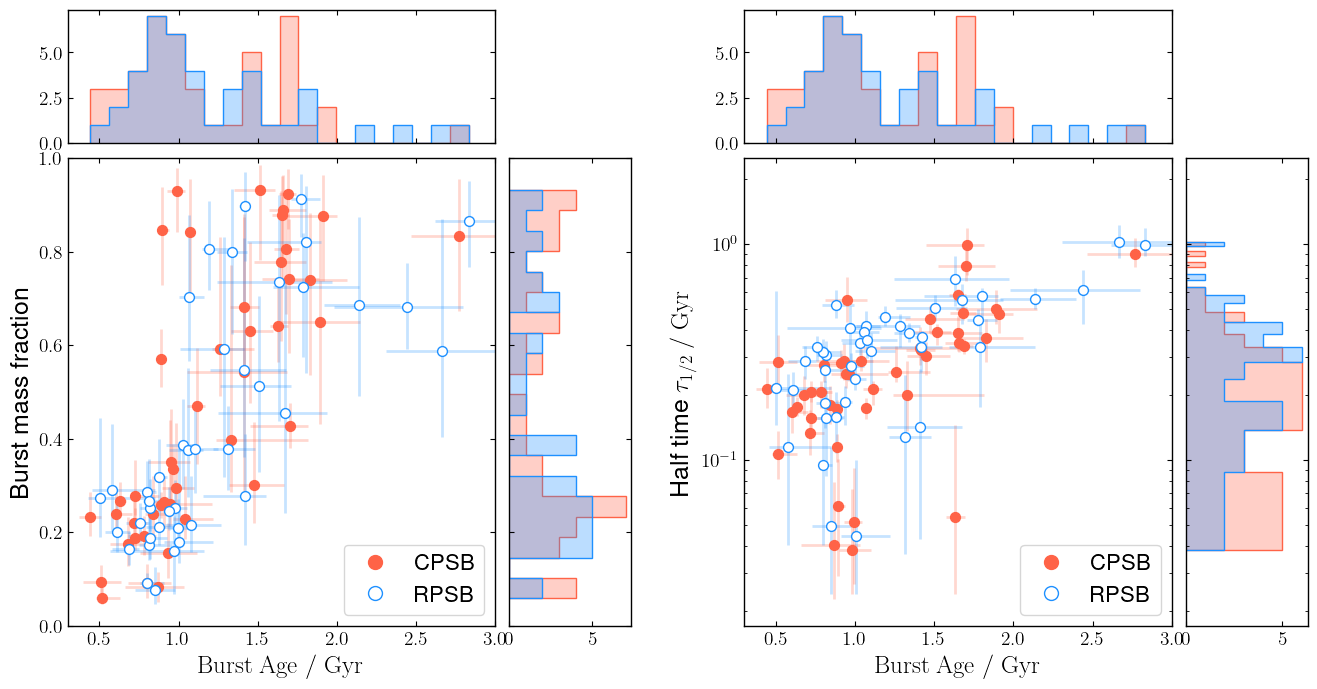

In [65]:
combined_twopanel(orientation='h', sel_prob=False, contour=False, save_name='CPSBvsRPSB_scatter_SFH_simple.pdf')

## Figure B2

[0.0, 1.0]


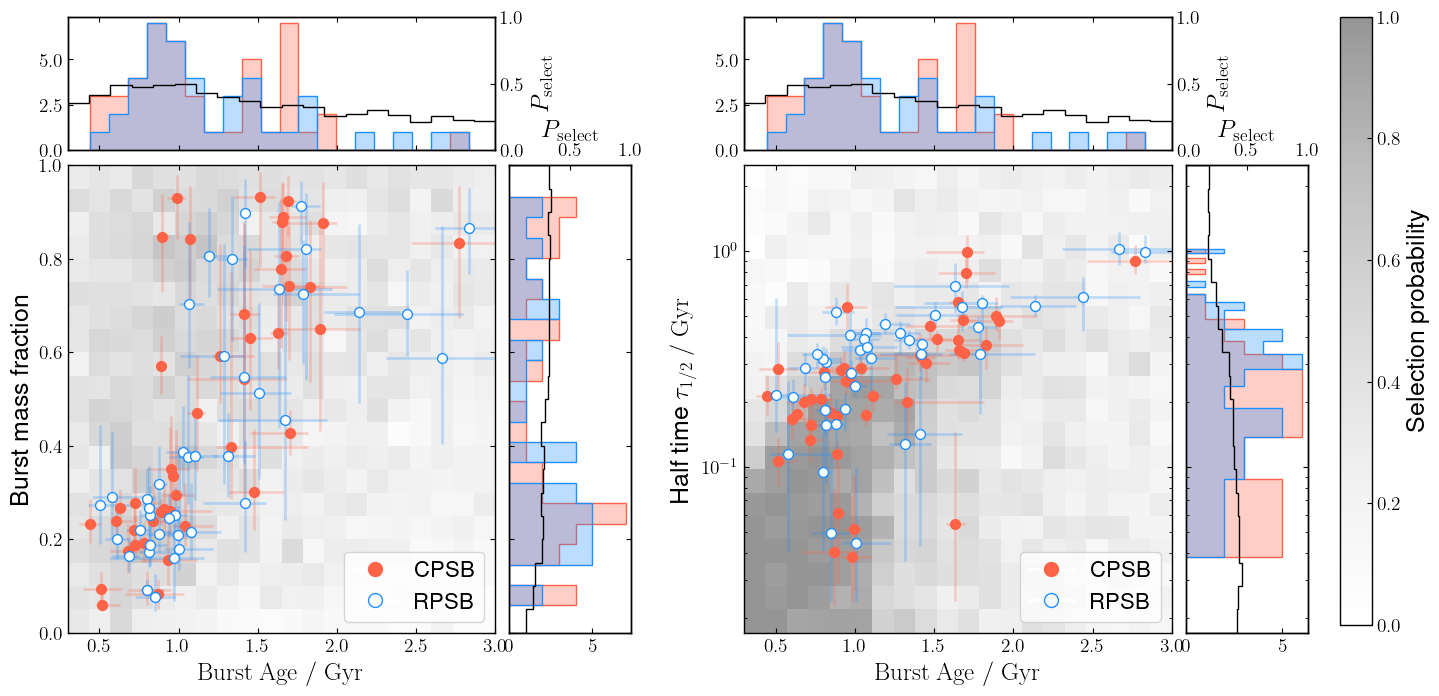

In [66]:
combined_twopanel(orientation='h', sel_prob=True, contour=False, save_name='CPSBvsRPSB_scatter_SFH.pdf')